This implementation is adapted from the work presented in *“FedSysID: A Federated Approach to Sample-Efficient System Identification.”*

The original source code is available at:
[https://github.com/jd-anderson/Federated-ID](https://github.com/jd-anderson/Federated-ID)

The referenced repository served as the foundational implementation framework for this codebase.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937, SeedSequence
from scipy.io import loadmat
# MATLAB-compatible random number generator
rs = Generator(MT19937(SeedSequence(42)))
import json

In [7]:
def sysgen(A_0, B_0, V, U, M, epsilon):
    """Generate client systems with variations"""
    with open('random_values.json', 'r') as f:
      random_values = json.load(f)
    A = [A_0 + epsilon *  rs.random() * V for i in range(M)]
    B = [B_0 + epsilon * rs.random() * U for i in range(M)]
    return A, B

In [8]:
def syssim(A, B, T, N, client_idx, sigu, sigw, sigx):
    """Trajectory simulation"""
    n = A[client_idx].shape[0]
    p = B[client_idx].shape[1]

    X_i = np.zeros((n, T*N), order='F')
    Z_i = np.zeros((n+p, T*N), order='F')

    for j in range(N):
        x = np.zeros((n, T+1), order='F')
        u = np.zeros((p, T), order='F')

        #  initialization with precision matching
        x[:, 0] = np.round(rs.normal(0, sigx, n), 9)

        for k in range(T):
            u[:, k] = np.round(rs.normal(0, sigu, p), 9)
            w = np.round(rs.normal(0, sigw, n), 9)

            if k < T:  
                x[:, k+1] = A[client_idx] @ np.sin(x[:, k]) + B[client_idx] @ u[:, k] + w

        #  array flipping and storage
        X_i[:, j*T:(j+1)*T] = np.fliplr(x[:, 1:])
        z_block = np.vstack([np.sin(x[:, :-1]), u])
        Z_i[:, j*T:(j+1)*T] = np.fliplr(z_block)

    return X_i, Z_i

In [9]:
def sysid(A, B, T, N, M, R, sigu, sigx, sigw, FL_solver, s,K):
    """Federated identification with dimension checks"""
    n = A[0].shape[0]
    p = B[0].shape[1]

    # Generate trajectories with dimension validation
    X, Z = [], []
    for i in range(M):
        X_i, Z_i = syssim(A, B, T, N, i, sigu, sigw, sigx)
        assert X_i.shape == (n, T*N), f"X_i shape mismatch: {X_i.shape}"
        assert Z_i.shape == (n+p, T*N), f"Z_i shape mismatch: {Z_i.shape}"
        # print(X_i)
        X.append(X_i)
        Z.append(Z_i)

    # Parameter initialization
    Theta_0 = np.hstack([0.5*A[s], 0.5*B[s]]).astype(np.float64, order='F')
    alpha = np.float64(1e-4)
    # K = 10
    Theta_s = Theta_0.copy()
    Error = np.zeros(R, dtype=np.float64)

    for r in range(R):
        Theta_c = [Theta_s.copy() for _ in range(M)]

        # Client updates with dimension-safe operations
        for i in range(M):
            if FL_solver == 1:  # FedLin
                global_grad = np.zeros_like(Theta_s, order='F')
                for j in range(M):
                    global_grad -= (X[j] - Theta_s @ Z[j]) @ Z[j].T
                global_grad /= M

                for k in range(K):
                    local_grad = -(X[i] - Theta_c[i] @ Z[i]) @ Z[i].T
                    correction = (X[i] - Theta_s @ Z[i]) @ Z[i].T + global_grad
                    Theta_c[i] -= alpha * (local_grad + correction)
            else:  # FedAvg
                for k in range(K):
                    grad = (X[i] - Theta_c[i] @ Z[i]) @ Z[i].T
                    Theta_c[i] += (alpha/(k+1)) * grad

        # Server aggregation with  mean
        Theta_s = np.mean(Theta_c, axis=0, dtype=np.float64)
        error=[]
        for k in range(M):
            error.append(np.linalg.norm(Theta_s -np.hstack([A[k],B[k]])) / np.linalg.norm(np.hstack([A[k],B[k]]))
                         )
        Error[r] = np.max(error)

    return Error

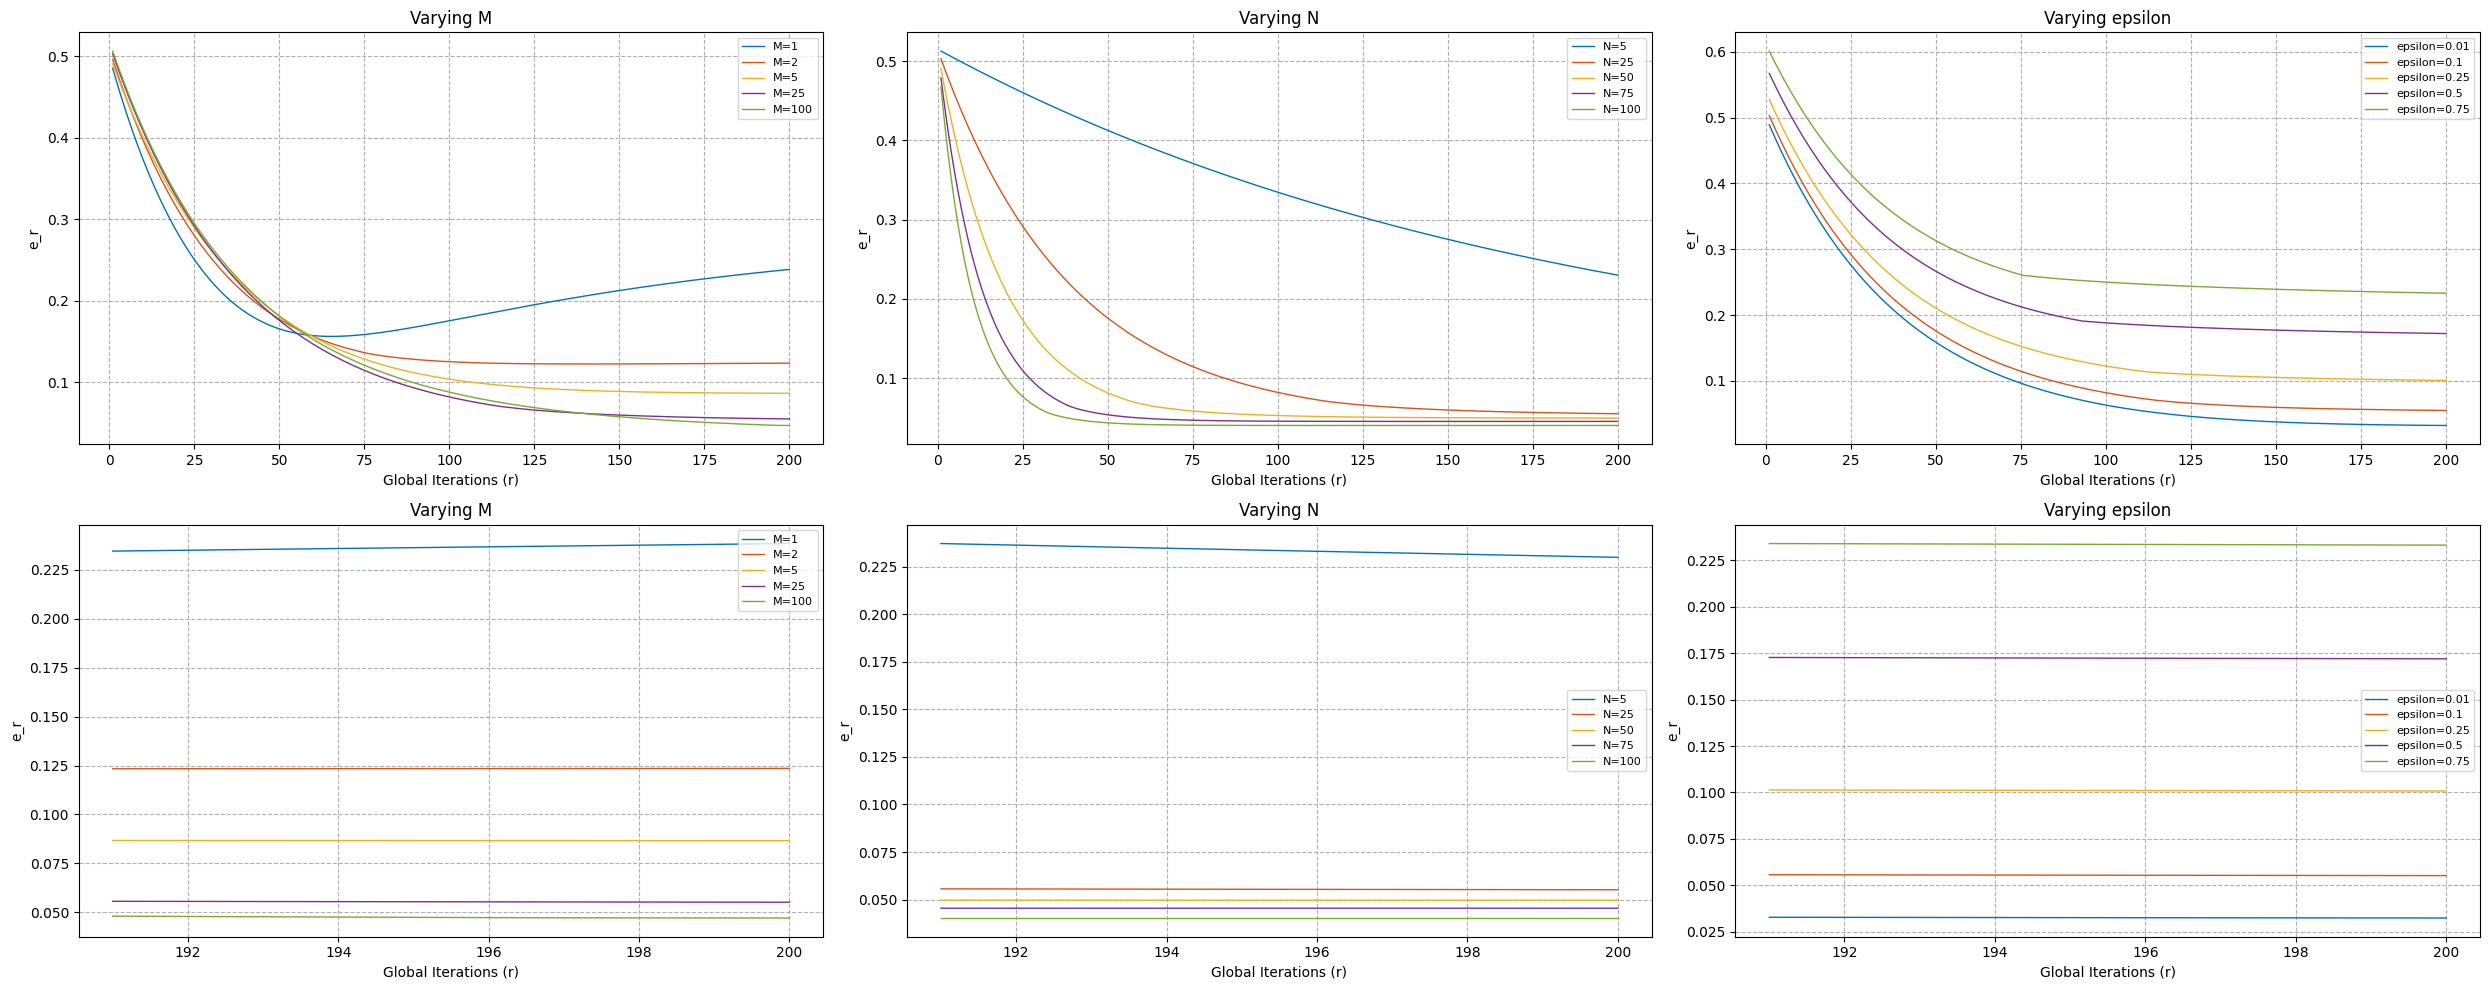

In [10]:
if __name__ == "__main__":
    n, p = 3, 2
    A_0 = np.array([[1, 0.2, 0.6],
                    [0.1, 0.4, 0.4],
                    [0.2, 0.3, 0.4]], dtype=np.float64, order='F')
    B_0 = np.array([[0.6, 0.8],
                    [1.0, 1.0],
                    [0.6, 0.5]], dtype=np.float64, order='F')
    V = np.diag([0, 1, 1]).astype(np.float64, order='F')
    U = np.array([[1, 0], [1, 0], [0, 1]], dtype=np.float64, order='F')

    # Simulation parameters
    sigu = np.float64(1)
    sigw = np.float64(1)
    sigx = np.float64(1)
    T = 5
    FL_solver = 0
    q, R, s = 1, 200, 0
    K=5
    param_configs = [
        ('M', [1,2,5,25,100], dict(N=25, epsilon=0.1)),
        ('N', [5,25, 50,75,100], dict(M=25, epsilon=0.1)),
        ('epsilon', [0.01, 0.1,0.25,0.5,0.75], dict(M=25, N=25))
    ]
    plt.figure(figsize=(25, 10), dpi=100)
    colors = ['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30']

    for plot_idx, (param, values, fixed) in enumerate(param_configs):
        plt.subplot(2, 3, plot_idx+1)
        last_ten_mean_error=[]
        for i, value in enumerate(values):
            rs = Generator(MT19937(SeedSequence(0)))  # Reset RNG for each trial
            params = {**fixed, param: value}
            A, B = sysgen(A_0, B_0, V, U, params['M'], params['epsilon'])
            # print(A[i])
            errors = np.zeros((q, R))
            for q_idx in range(q):
                errors[q_idx] = sysid(A, B, T, params['N'], params['M'], R,
                                    sigu, sigx, sigw, FL_solver, s,K)

            mean_error = np.mean(errors, axis=0)
            # print(mean_error[0:10])
            # plt.semilogy(range(R), mean_error, color=colors[i], linewidth=1.5)
            plt.plot(range(1, R+1), mean_error, color=colors[i], linewidth=1)
            last_ten_mean_error.append(mean_error[-10:])

        plt.xlabel('Global Iterations (r)', fontsize=10)
        plt.ylabel('e_r', fontsize=10)
        plt.grid(True, which='both', linestyle='--')
        plt.title(f'Varying {param}', fontsize=12)
        plt.legend([f'{param}={v}' for v in values], fontsize=8)
        plt.subplot(2, 3, plot_idx+4)
        for i in range(len(last_ten_mean_error)):
            plt.plot(range(R-9, R+1), last_ten_mean_error[i], color=colors[i], linewidth=1)


        plt.xlabel('Global Iterations (r)', fontsize=10)
        plt.ylabel('e_r', fontsize=10)
        plt.grid(True, which='both', linestyle='--')
        plt.title(f'Varying {param}', fontsize=12)
        plt.legend([f'{param}={v}' for v in values], fontsize=8)

    plt.tight_layout()
    # plt.savefig('Exp.png')
    plt.show()

In [11]:
n, p = 3, 2
A_0 = np.array([[1, 0.2, 0.6],
                    [0.1, 0.4, 0.4],
                    [0.2, 0.3, 0.4]], dtype=np.float64, order='F')
B_0 = np.array([[0.6, 0.8],
                    [1.0, 1.0],
                    [0.6, 0.5]], dtype=np.float64, order='F')
V = np.diag([0, 1, 1]).astype(np.float64, order='F')
U = np.array([[1, 0], [1, 0], [0, 1]], dtype=np.float64, order='F')

# Simulation parameters
sigu = np.float64(1)
sigw = np.float64(1)
sigx = np.float64(1)
T = 5
FL_solver = 0
q, R, s = 1, 200, 0
K=5

# Varying M

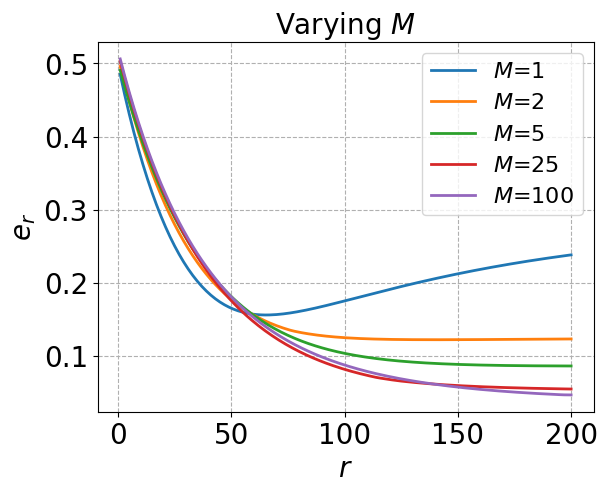

In [12]:
M=[1,2,5,25,100]
client_error_=[]
for index,m in enumerate(M):
    rs = Generator(MT19937(SeedSequence(0)))
    errors = np.zeros((q, R))
    A, B = sysgen(A_0, B_0, V, U,m,0.1)
    errors = np.zeros((q, R))
    for q_idx in range(q):
        errors[q_idx] = sysid(A, B, T,25, m, R,
                            sigu, sigx, sigw, FL_solver, s,K)

    mean_error = np.mean(errors, axis=0)
    client_error_.append(mean_error[-1])
    plt.plot(range(1, R+1), mean_error, label=f'$M$={M[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    plt.xticks(fontsize=20)  # Increase x-axis tick font size
    plt.yticks(fontsize=20) 
    plt.xticks(np.linspace(0, 200, 5)) 

    plt.title(r'Varying $M$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
# plt.savefig('synthetic_sys_id_K=5_M.png',bbox_inches='tight')

# Varying N

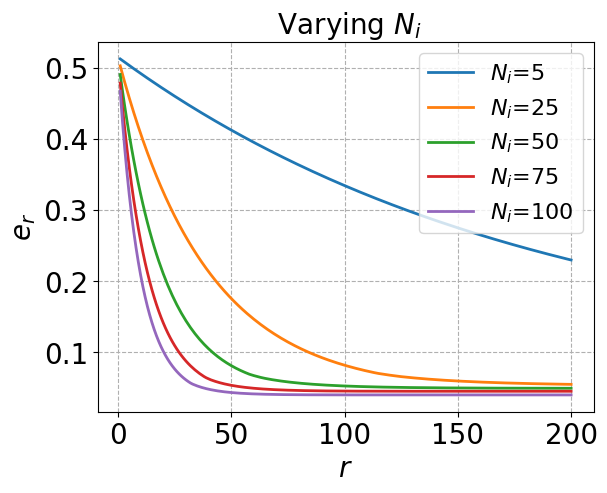

In [ ]:
N=[5,25, 50,75,100]
client_error=[]
M=25
for index,n in enumerate(N):
    rs = Generator(MT19937(SeedSequence(0)))
    errors = np.zeros((q, R))
    A, B = sysgen(A_0, B_0, V, U,M,0.1)
    errors = np.zeros((q, R))
    for q_idx in range(q):
        errors[q_idx] = sysid(A, B, T,n, M, R,
                            sigu, sigx, sigw, FL_solver, s,K)

    mean_error = np.mean(errors, axis=0)
    client_error.append(mean_error[-1])
    plt.plot(range(1, R+1), mean_error, label=f'$N_i$={N[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    plt.xticks(fontsize=20)  # Increase x-axis tick font size
    plt.yticks(fontsize=20) 
    plt.xticks(np.linspace(0, 200, 5)) 

    plt.title(' Varying $N_i$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
# plt.savefig('synthetic_sys_id_K=5_N.png',bbox_inches='tight')

# Varying epsilon

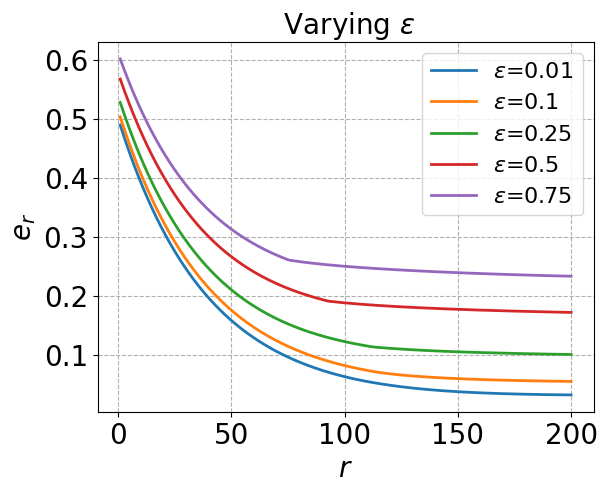

In [ ]:
epsilon=[0.01, 0.1,0.25,0.5,0.75]
# client_error=[]
M=25
N=25
for index,eps in enumerate(epsilon):
    rs = Generator(MT19937(SeedSequence(0)))
    errors = np.zeros((q, R))
    A, B = sysgen(A_0, B_0, V, U,M,eps)
    errors = np.zeros((q, R))
    for q_idx in range(q):
        errors[q_idx] = sysid(A, B, T,N, M, R,
                            sigu, sigx, sigw, FL_solver, s,K)

    mean_error = np.mean(errors, axis=0)
    # client_error.append(mean_error[-1])
    plt.plot(range(1, R+1), mean_error, label=f'$\epsilon$={epsilon[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    plt.xticks(fontsize=20)  # Increase x-axis tick font size
    plt.yticks(fontsize=20) 
    plt.xticks(np.linspace(0, 200, 5)) 

    plt.title(' Varying $\epsilon$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
# plt.savefig('synthetic_sys_id_K=5_eps.png',bbox_inches='tight')